## Exploratory Data Analysis: Construction & Macroeconomic Series
This notebook explores macro and material-related time series with the goals of:
1. Inspecting raw trends, regimes, and potential seasonality.
2. Assessing contemporaneous relationships (with caveats about non-stationarity).
3. Generating hypotheses for feature engineering (lags, transformations, stationarity tests).

We follow a narrative flow: describe intent → run code → interpret output.

In [16]:
import os
from pathlib import Path
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root not found (looked for: {}).".format(", ".join(markers)))

project_root = find_project_root()

# Load environment variables
load_dotenv(project_root / ".env")

# Prefer alembic URL if present, else fallback
DATABASE_URL = (
    os.getenv("DATABASE_URL_ALEMBIC")
    or os.getenv("DATABASE_URL")
)

if not DATABASE_URL:
    raise ValueError("DATABASE_URL_ALEMBIC or DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)

df = pd.read_sql_table("raw_series", engine, index_col="id")
df["date"] = pd.to_datetime(df["date"])

# Figure output directory
img_dir = project_root / "docs" / "img"
img_dir.mkdir(parents=True, exist_ok=True)

print("Data loaded successfully. Rows:", len(df))
display(df.head())
print("\nData info:")
df.info()

Data loaded successfully. Rows: 5042


,series_id,date,value,source
id,,,,
5043,PPI_STEEL,1982-06-01,100.0,FRED
5044,PPI_STEEL,1982-07-01,100.0,FRED
5045,PPI_STEEL,1982-08-01,100.0,FRED
5046,PPI_STEEL,1982-09-01,100.0,FRED
5047,PPI_STEEL,1982-10-01,99.6,FRED



Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 5043 to 10084
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  5042 non-null   object        
 1   date       5042 non-null   datetime64[ns]
 2   value      5042 non-null   float64       
 3   source     5042 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 197.0+ KB


### 1. Initial Data Load & Structure
The table above (head + info) confirms:
- Long format structure with columns: `date`, `series_id`, `value` (plus index id).
- Dates parsed to datetime successfully; no dtype coercion issues.
- Row count suggests multiple monthly economic & material series spanning multiple macro regimes.

Planned immediate quality checks (future enhancement):
- Uniqueness of (date, series_id) pairs.
- Completeness: detect any missing monthly periods per series.
- Early detection of structural breaks or sudden level shifts.

Proceeding next to per-series visualization to visually assess trend, seasonality, and volatility.

In [20]:
# --- Data Quality Helper ---
# 1. Duplicate (date, series_id) check
dup_count = df.duplicated(subset=["date", "series_id"]).sum()
print(f"Duplicate (date, series_id) pairs: {dup_count}")

# 2. Missing values summary
missing_summary = df.isna().sum()
print("\nMissing values per column:\n", missing_summary)

# 3. Per-series monthly coverage & missing month detection
# Assumes monthly frequency; derive expected full month range per series
from collections import defaultdict
import numpy as np

coverage_records = []
missing_months_records = defaultdict(list)

for series, g in df.groupby("series_id"):
    g_sorted = g.sort_values("date")
    start, end = g_sorted.date.min(), g_sorted.date.max()
    full_index = pd.date_range(start=start, end=end, freq="MS")
    present = pd.to_datetime(g_sorted.date.unique())
    present_months = pd.to_datetime(pd.Series(present)).dt.to_period('M')
    full_months = pd.Series(full_index).dt.to_period('M')
    missing = set(full_months) - set(present_months)
    coverage = 1 - (len(missing) / len(full_months) if len(full_months)>0 else 0)
    coverage_records.append({"series_id": series, "start": start, "end": end, "months_expected": len(full_months), "months_present": len(present_months), "coverage_ratio": round(coverage,4), "missing_months": len(missing)})
    if missing:
        for m in sorted(missing):
            missing_months_records[series].append(str(m))

coverage_df = pd.DataFrame(coverage_records).sort_values("coverage_ratio")
print("\nPer-series coverage summary:")
display(coverage_df)

if any(missing_months_records.values()):
    print("\nMissing months detected (first few per series):")
    for s, months in missing_months_records.items():
        print(f"  {s}: {months[:10]}{' ...' if len(months)>10 else ''}")
else:
    print("\nNo missing months detected across series (monthly continuity).")

Duplicate (date, series_id) pairs: 0

Missing values per column:
 series_id    0
date         0
value        0
source       0
dtype: int64

Per-series coverage summary:


,series_id,start,end,months_expected,months_present,coverage_ratio,missing_months
0,CPI_ALL,1947-01-01,2025-08-01,944,944,1.0,0
1,FED_FUNDS_RATE,1954-07-01,2025-09-01,855,855,1.0,0
2,HOUSING_STARTS,1959-01-01,2025-08-01,800,800,1.0,0
3,PPI_CONCRETE,1965-01-01,2025-08-01,728,728,1.0,0
4,PPI_LUMBER,1926-01-01,2025-08-01,1196,1196,1.0,0
5,PPI_STEEL,1982-06-01,2025-08-01,519,519,1.0,0



No missing months detected across series (monthly continuity).


Saved time series figure to: /Users/vijaykhot/material-forecasting-engine/docs/img/time_series_plots.png


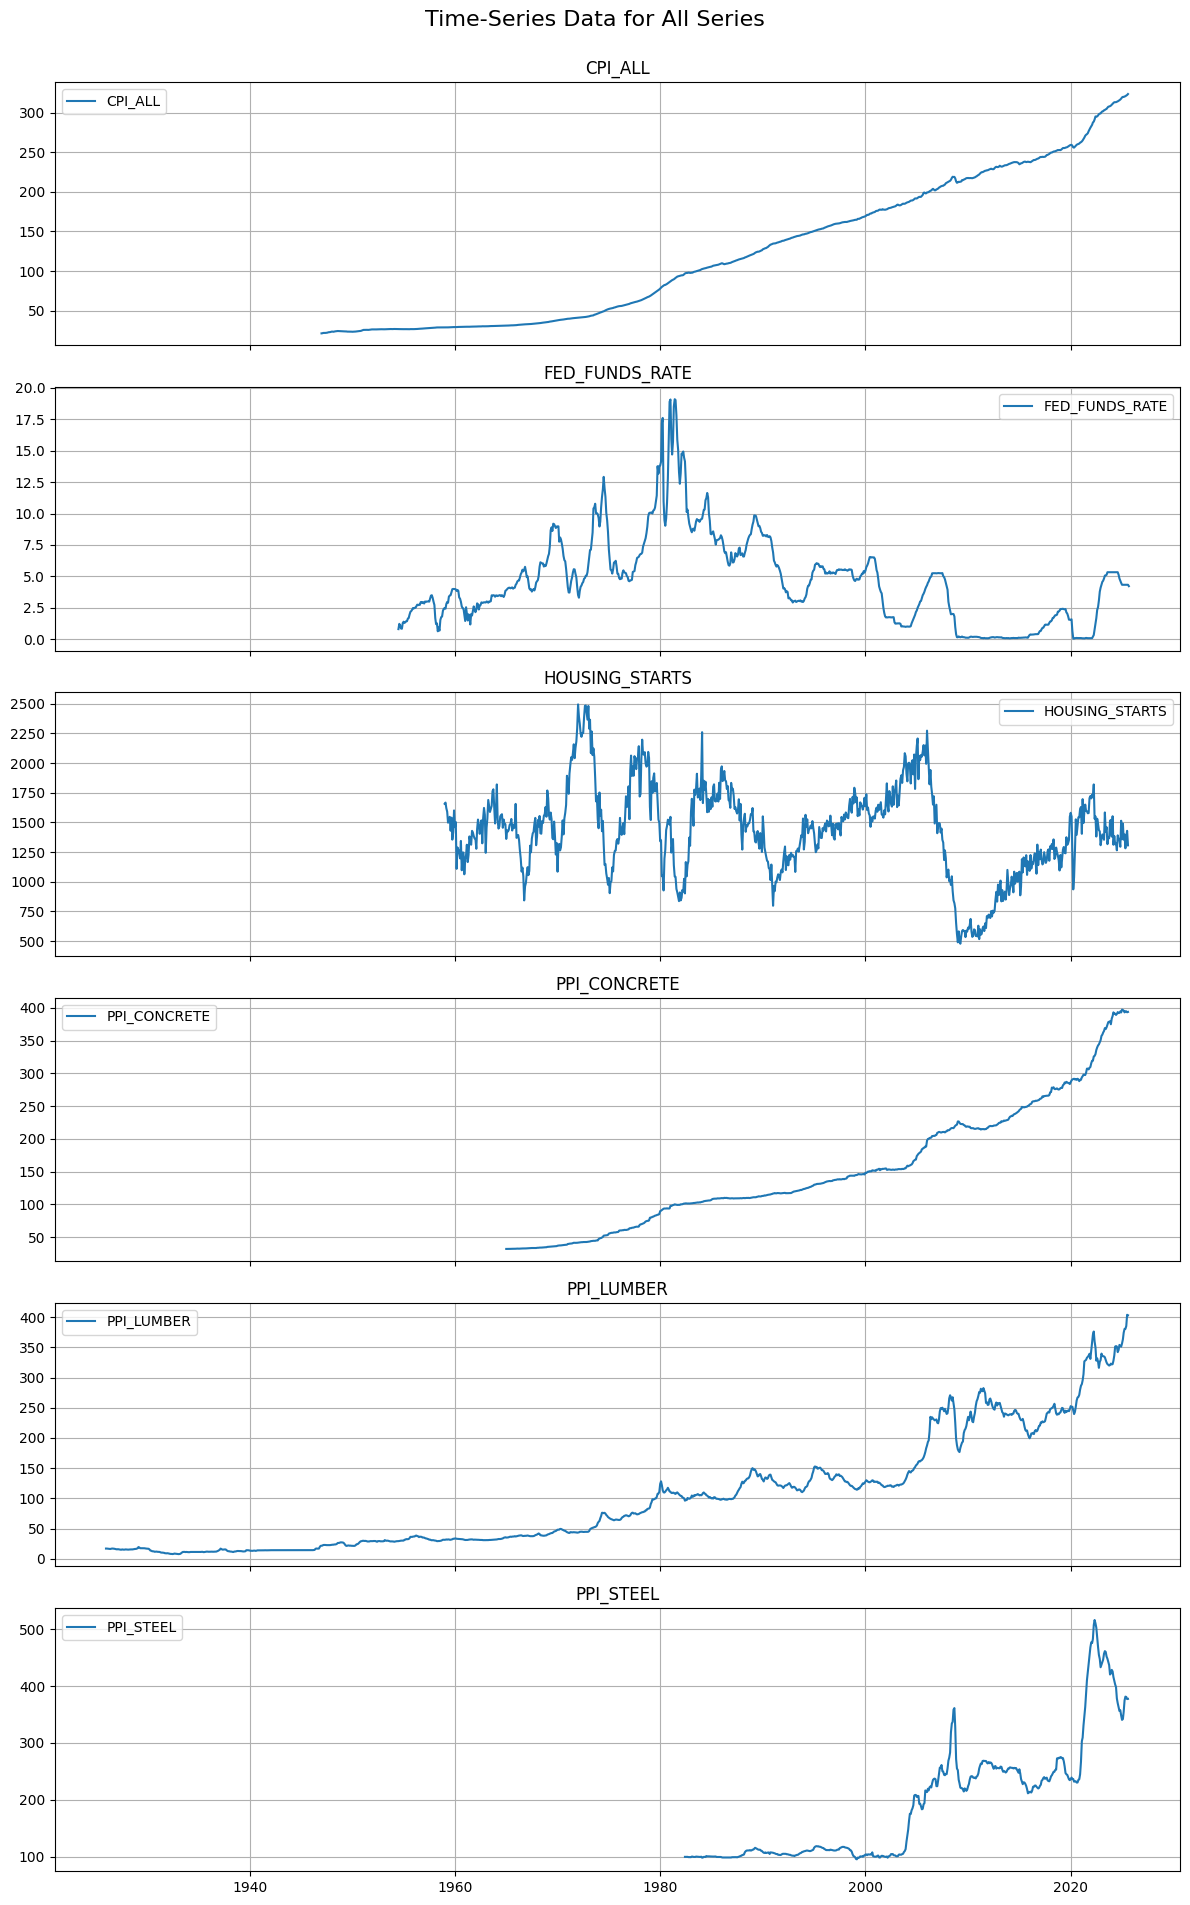

In [23]:
# --- 2. TIME-SERIES VISUALIZATION ---
# Pivot the data to have dates as the index and series_id as columns
df_pivot = df.pivot(index='date', columns='series_id', values='value')

# Create subplots for each series
fig, axes = plt.subplots(nrows=len(df_pivot.columns), ncols=1, figsize=(12, 20), sharex=True)
fig.suptitle('Time-Series Data for All Series', fontsize=16)

for i, col in enumerate(df_pivot.columns):
    axes[i].plot(df_pivot.index, df_pivot[col], label=col)
    axes[i].set_title(col)
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plot_path = img_dir / 'time_series_plots.png'
plt.savefig(plot_path)  # Save the figure
print(f"Saved time series figure to: {plot_path}")
plt.show()

### 2.1 Observations from Plots
Preliminary qualitative insights:
- `CPI_ALL`: Strong upward drift (price level) → non-stationary; will require differencing or YoY % changes.
- `FED_FUNDS_RATE`: Clear policy regimes (early high-rate era, ZIRP, rapid tightening). Suggests regime indicators or structural break handling.
- `HOUSING_STARTS`: Cyclical + potential seasonality with pronounced downturns (GFC, pandemic).
- Commodity PPIs (e.g., steel, lumber): Volatility spikes around 2020–2022; log transform may stabilize variance.
Implication: Direct level correlations risk spurious relationships. Next step: cautious correlation analysis with caveats.

## 2. Visual Inspection of Individual Series
Objective: Identify trend, seasonality, volatility regimes, and anomalous spikes before any transformations.
Rationale: Early visual cues guide whether to difference, log-transform, or segment by regimes.
Method: Pivot long-form data to wide format and plot each `series_id` in a separate panel sharing the date axis.

Saved correlation heatmap to: /Users/vijaykhot/material-forecasting-engine/docs/img/correlation_heatmap.png


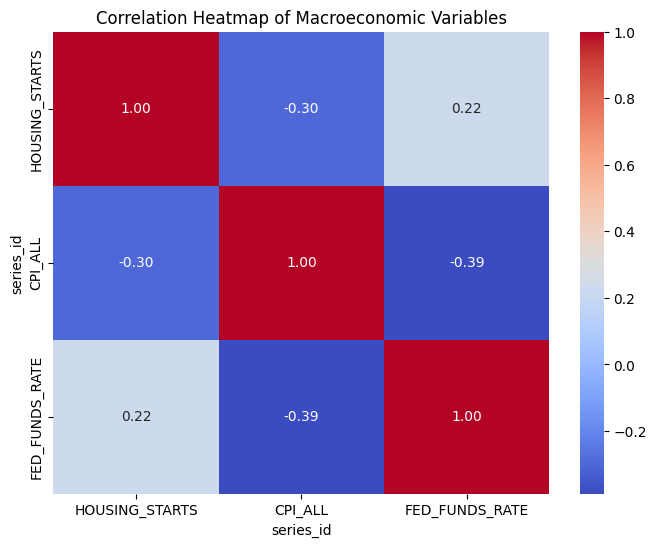

series_id,HOUSING_STARTS,CPI_ALL,FED_FUNDS_RATE
series_id,,,
HOUSING_STARTS,1.000000,-0.298705,0.224532
CPI_ALL,-0.298705,1.000000,-0.388712
FED_FUNDS_RATE,0.224532,-0.388712,1.000000


In [25]:
# --- 3. CORRELATION ANALYSIS ---
# Filter for only the macroeconomic indicators
macro_df = df_pivot[['HOUSING_STARTS', 'CPI_ALL', 'FED_FUNDS_RATE']]

# Calculate the correlation matrix
correlation_matrix = macro_df.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Macroeconomic Variables')
corr_path = img_dir / 'correlation_heatmap.png'
plt.savefig(corr_path)  # Save the figure
print(f"Saved correlation heatmap to: {corr_path}")
plt.show()

display(correlation_matrix)

### 3.1 Correlation Interpretation
Preliminary patterns (to be validated with transformed data):
- Negative CPI vs Housing correlation may reflect affordability pressure + policy response cycles.
- FED_FUNDS_RATE vs CPI shows contemporaneous negative value: policy tightening often follows inflation spikes (lag effects).
- Mild positive FED_FUNDS_RATE vs Housing in levels likely spurious due to shared long-horizon cycles.
Action: Recompute on (log) differences and include lags to test causal ordering.

## 3. Contemporaneous Correlation (Exploratory)
Goal: Get a first-pass sense of linear relationships among selected macro variables.
Caveats:
- Variables in levels and trending → risk of spurious correlation.
- No lag structure captured (policy effects often lag housing).
- Pearson correlation assumes stationarity and homoscedasticity.
Next refinement: Use differenced / growth-rate series and lag matrices.

## 4. Risks & Data Quality Considerations
- Non-stationarity: Level indices (CPI, PPIs) and policy rates require differencing / growth transforms.
- Structural breaks: Pandemic + rapid tightening phase may need regime flags.
- Volatility shifts: Commodity PPIs show heteroskedasticity; consider log transform and rolling variance profiling.
- Potential missing months: To verify in follow-up quality check.

## 5. Next Analytical Steps
1. Create transformed series: log, first diff, YoY % change.
2. Build lag features (1–12) for Housing vs Rates, Materials vs Housing.
3. Stationarity testing (ADF, KPSS) + seasonal decomposition (STL) for key series.
4. Rolling correlation / dynamic regression to test stability over regimes.
5. Structural break detection (e.g., Bai–Perron via external tooling or segmented regression).
6. Persist a wide monthly feature matrix for modeling.

## 6. Preliminary Hypotheses
1. Rate hikes (Fed Funds) precede Housing downturns with a 3–9 month lag.
2. Material cost spikes (Steel, Lumber) amplify housing slowdown risk when rates are elevated.
3. CPI trend removal (real adjustments) will strengthen inverse Housing vs Rates relationship.
4. Pandemic regime behaves as an outlier cluster requiring segmentation.

## 7. Action Items Checklist
- [ ] Validate uniqueness of (date, series_id).
- [ ] Create completeness report per series.
- [ ] Generate transformed (log/diff/YoY) features.
- [ ] Produce lagged correlation heatmaps.
- [ ] Run ADF/KPSS tests + summarize.
- [ ] Add regime flags and re-test correlations.
- [ ] Export processed dataset (parquet).

## 8. Reproducibility Notes
- Paths derived from dynamic `project_root`; no hard-coded user-specific paths.
- Environment variables loaded from `.env` (no secrets in notebook).
- Figures can be regenerated; consider versioning cleaned data and transformation scripts.
Future improvement: Automate via a Makefile or pipeline (e.g., `papermill` / `Prefect`).